In [80]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np 
from torchvision.datasets import MNIST
from scipy.spatial.distance import cdist




In [57]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the data to a tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize the data to have mean 0.1307 and standard deviation 0.3081
])

# Load the MNIST dataset
mnist_train = datasets.MNIST(root='../Data/Mnist_test_data/', train=True, download=True, transform=transform)
# Load the MNIST dataset
train_dataset = datasets.MNIST(root='../Data/Mnist_test_data/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Train the VAE model

In [48]:

class VAE(nn.Module):
    def __init__(self, latent_dim=8):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim * 2)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h[:, :self.latent_dim], h[:, self.latent_dim:]
        return mu, logvar

    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar


In [49]:
 # Loss function: reconstruction loss + KL divergence loss
def loss_function(x_hat, x, z_mean, z_logvar):
        bce_loss = nn.functional.binary_cross_entropy(x_hat, x.view(-1, 784), reduction='sum')
        kld_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
        return bce_loss + kld_loss

In [50]:
# Define the VAE model
model = VAE()

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the training parameters
learning_rate = 1e-3
num_epochs = 50
batch_size = 128


# Define the training function
def train(model, train_loader, learning_rate, num_epochs, device):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Loss function: reconstruction loss + KL divergence loss
    def loss_function(x_hat, x, z_mean, z_logvar):
        bce_loss = nn.functional.binary_cross_entropy(x_hat, x.view(-1, 784), reduction='sum')
        kld_loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
        return bce_loss + kld_loss

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.to(device)
            optimizer.zero_grad()
            x_hat, z_mean, z_logvar = model(x)
            loss = loss_function(x_hat, x, z_mean, z_logvar)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()

        avg_loss = total_loss / len(train_loader.dataset)
        print('Epoch [{}/{}], Average Loss: {:.4f}'.format(epoch+1, num_epochs, avg_loss))

        # Generate and save a sample image every 5 epochs
        if (epoch+1) % 10 == 0:
            with torch.no_grad():
                z = torch.randn(64, model.latent_dim).to(device)
                sample = model.decode(z).view(64, 1, 28, 28)
                save_image(sample, 'vae_samples_epoch{}.png'.format(epoch+1))



In [59]:

# Train the VAE model using the train function
train(model, train_loader, learning_rate, num_epochs, device)

Epoch [1/50], Average Loss: 191.4742
Epoch [2/50], Average Loss: 124.2454
Epoch [3/50], Average Loss: 119.3989
Epoch [4/50], Average Loss: 116.4345
Epoch [5/50], Average Loss: 114.3915
Epoch [6/50], Average Loss: 112.8904
Epoch [7/50], Average Loss: 111.6972
Epoch [8/50], Average Loss: 110.7723
Epoch [9/50], Average Loss: 110.0130
Epoch [10/50], Average Loss: 109.2854
Epoch [11/50], Average Loss: 108.7344
Epoch [12/50], Average Loss: 108.2259
Epoch [13/50], Average Loss: 107.7334
Epoch [14/50], Average Loss: 107.3311
Epoch [15/50], Average Loss: 106.9086
Epoch [16/50], Average Loss: 106.5830
Epoch [17/50], Average Loss: 106.2835
Epoch [18/50], Average Loss: 105.9943
Epoch [19/50], Average Loss: 105.6952
Epoch [20/50], Average Loss: 105.4415
Epoch [21/50], Average Loss: 105.1681
Epoch [22/50], Average Loss: 104.9648
Epoch [23/50], Average Loss: 104.7177
Epoch [24/50], Average Loss: 104.5074
Epoch [25/50], Average Loss: 104.3483
Epoch [26/50], Average Loss: 104.1571
Epoch [27/50], Averag

In [169]:
torch.save(VAE.state_dict(model), '../Model/VAE_Mnist.pth')

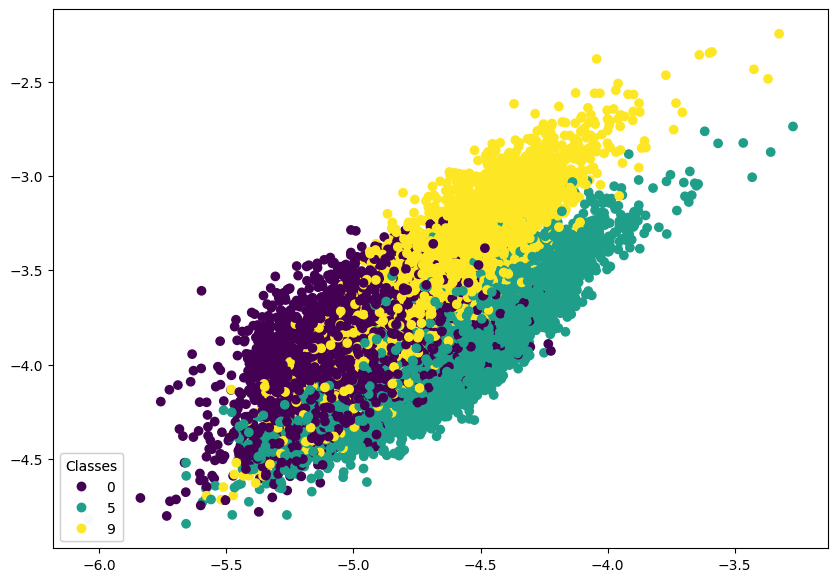

In [118]:

# Define the subset of MNIST data to visualize
indices = torch.where((mnist_train.targets == 0)  | (mnist_train.targets == 9)|(mnist_train.targets == 5))[0]
mnist_subset = mnist_train.data[indices]
mnist_subset_targets = mnist_train.targets[indices]

# Pass the subset to a DataLoader
batch_size = 64
subset_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mnist_subset.float().unsqueeze(1)/255.), batch_size=batch_size)

# Get the latent representations of the subset
with torch.no_grad():
    latent_vectors = []
    for batch in subset_loader:
        batch = batch[0].to(device)
        _, _, z = model(batch)
        latent_vectors.append(z)
    latent_vectors = torch.cat(latent_vectors, dim=0)

# Visualize the latent vectors
fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=mnist_subset_targets, cmap='viridis')
legend = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
ax.add_artist(legend)
plt.show()


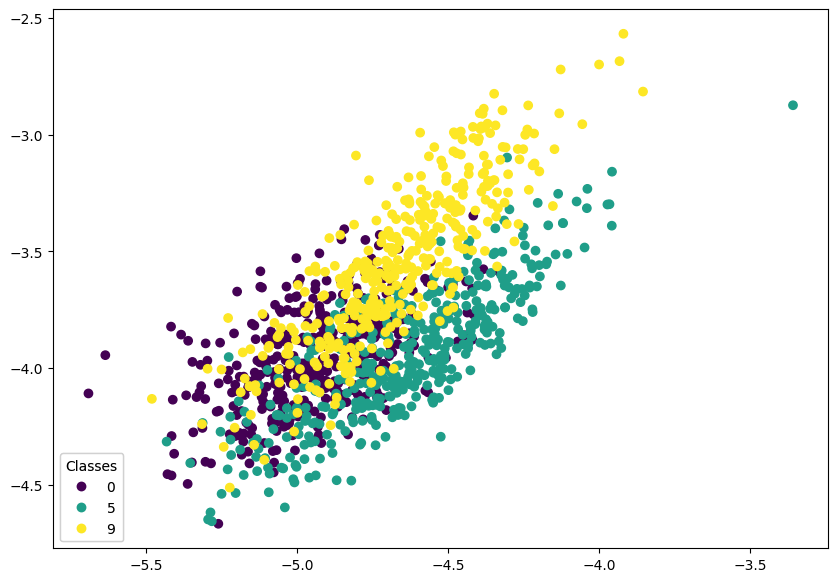

In [127]:
import random

# Define the subset of MNIST data to visualize
indices = torch.where((mnist_train.targets == 0)  | (mnist_train.targets == 9)|(mnist_train.targets == 5))[0]
mnist_subset = mnist_train.data[indices]
mnist_subset_targets = mnist_train.targets[indices]

# Select 500 samples from each class randomly
samples_per_class = 400
class_indices = []
for i in [0,  5,9]:
    class_i_indices = torch.where(mnist_subset_targets == i)[0]
    selected_indices = random.sample(class_i_indices.tolist(), samples_per_class)
    class_indices += selected_indices

# Use the selected indices to get the subset
mnist_subset = mnist_subset[class_indices]
mnist_subset_targets = mnist_subset_targets[class_indices]

# Pass the subset to a DataLoader
batch_size = 64
subset_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mnist_subset.float().unsqueeze(1)/255.), batch_size=batch_size)

# Get the latent representations of the subset
with torch.no_grad():
    latent_vectors = []
    for batch in subset_loader:
        batch = batch[0].to(device)
        _, _, z = model(batch)
        latent_vectors.append(z)
    latent_vectors = torch.cat(latent_vectors, dim=0)

# Visualize the latent vectors
fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=mnist_subset_targets, cmap='viridis')
legend = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
ax.add_artist(legend)
plt.show()


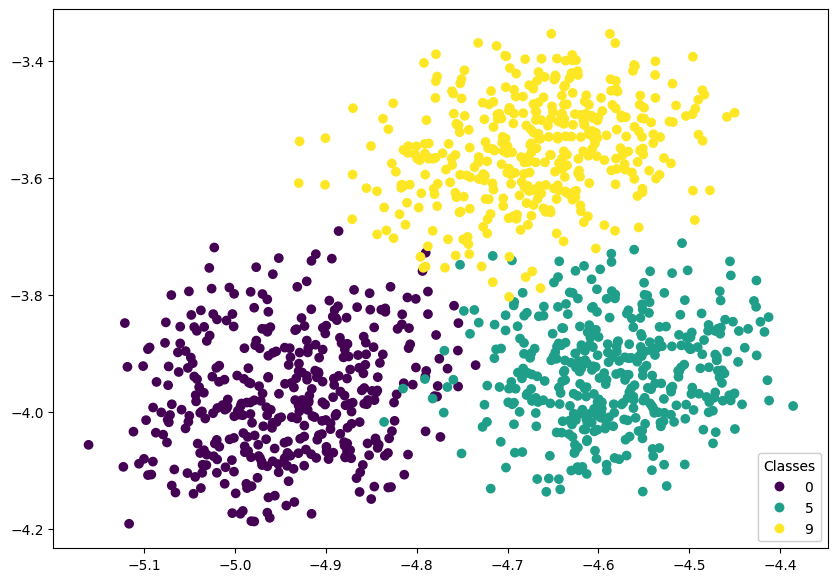

In [294]:
import torch
import numpy as np

# Define the subset of MNIST data to visualize
indices = torch.where((mnist_train.targets == 0)  | (mnist_train.targets == 9)|(mnist_train.targets == 5))[0]
mnist_subset = mnist_train.data[indices]
mnist_subset_targets = mnist_train.targets[indices]

# Pass the subset to a DataLoader
batch_size = 64
subset_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mnist_subset.float().unsqueeze(1)/255.), batch_size=batch_size)

# Get the latent representations of the subset
with torch.no_grad():
    latent_vectors = []
    for batch in subset_loader:
        batch = batch[0].to(device)
        _, _, z = model(batch)
        latent_vectors.append(z)
    latent_vectors = torch.cat(latent_vectors, dim=0)

# Compute the mean of the latent vectors for each class
means = []
for i in [0,5,9]:
    class_indices = (mnist_subset_targets == i).nonzero().squeeze()
    class_vectors = latent_vectors[class_indices]
    mean = class_vectors.mean(dim=0)
    means.append(mean)

# Select x samples from each class that are close to the mean, but not too close
num_samples = 400
sample_indices = []
for i, mean in zip([0,5,9], means):
    class_indices = (mnist_subset_targets == i).nonzero().squeeze()
    class_vectors = latent_vectors[class_indices]
    distances = np.linalg.norm(class_vectors - mean.cpu().numpy(), axis=1)
    sorted_indices = np.argsort(distances)
    closest_indices = sorted_indices[:num_samples//2]
    farthest_indices = sorted_indices[num_samples//2:num_samples]
    sample_indices.extend(class_indices[closest_indices].tolist())
    sample_indices.extend(class_indices[farthest_indices].tolist())

# Select the samples from the subset and their corresponding targets
mnist_subset = mnist_subset[sample_indices]
mnist_subset_targets = mnist_subset_targets[sample_indices]

# Pass the subset to a DataLoader
subset_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mnist_subset.float().unsqueeze(1)/255.), batch_size=batch_size)

# Get the latent representations of the subset
with torch.no_grad():
    latent_vectors = []
    for batch in subset_loader:
        batch = batch[0].to(device)
        _, _, z = model(batch)
        latent_vectors.append(z)
    latent_vectors = torch.cat(latent_vectors, dim=0)

# Visualize the latent vectors
fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=mnist_subset_targets, cmap='viridis')
legend = ax.legend(*scatter.legend_elements(), loc="lower right", title="Classes")
ax.add_artist(legend)
plt.show()


In [264]:
latent_vectors.shape

torch.Size([1200, 8])

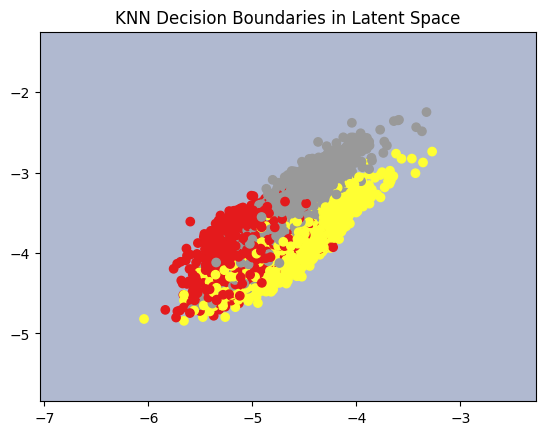

In [293]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



with torch.no_grad():
    latent_vectors = []
    for batch in subset_loader:
        batch = batch[0].to(device)
        _, _, z = model(batch)
        latent_vectors.append(z)
    latent_vectors = torch.cat(latent_vectors, dim=0)


    

# Define the number of neighbors for the KNN model
n_neighbors = 5

# Convert the latent space vectors to numpy array
X = np.array(latent_vectors)

# Convert the labels to numpy array
y = np.array(mnist_subset_targets)

# Create a KNN model and fit the data
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

# Compute decision boundaries
xmin, xmax = X[:, 0].min() - 1, X[:, 0].max() + 1
ymin, ymax = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel(), np.zeros((10000, 6))])
Z = Z.reshape(xx.shape)

# Plot decision boundaries
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1)
plt.title('KNN Decision Boundaries in Latent Space')
plt.show()

In [290]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Define the subset of MNIST data to visualize
indices = torch.where((mnist_train.targets == 0) | (mnist_train.targets == 5) | (mnist_train.targets == 9))[0]
mnist_subset = mnist_train.data[indices]
mnist_subset_targets = mnist_train.targets[indices]

# Pass the subset to a DataLoader
batch_size = 64
subset_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mnist_subset.float().unsqueeze(1)/255.), batch_size=batch_size)

# Get the latent representations of the subset
with torch.no_grad():
    latent_vectors = []
    for batch in subset_loader:
        batch = batch[0].to(device)
        _, _, z = model(batch)
        latent_vectors.append(z)
    latent_vectors = torch.cat(latent_vectors, dim=0)

# Define the number of neighbors for the KNN model
n_neighbors = 5

# Convert the latent space vectors to numpy array
X = np.array(latent_vectors)

# Convert the labels to numpy array
y = np.array(mnist_subset_targets)

# Create a KNN model and fit the data
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

# Compute decision boundaries
xmin, xmax = X[:, 0].min() - 1, X[:, 0].max() + 1
ymin, ymax = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundaries
fig, ax = plt.subplots(figsize=(10, 7))
ax.contourf(xx, yy, Z, alpha=0.4)
scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
legend = ax.legend(*scatter.legend_elements(), loc="lower right", title="Classes")
ax.add_artist(legend)
plt.title('KNN Decision Boundaries in Latent Space')
plt.show()

# Evaluate the accuracy of the KNN model
y_pred = knn.predict(X)
accuracy = accuracy_score(y, y_pred)
print(f"Accuracy of KNN classifier: {accuracy:.4f}")


ValueError: X has 2 features, but KNeighborsClassifier is expecting 8 features as input.